# motivating example under assumptions

In [15]:
import sys
import numpy as np
from graphviz import Digraph, Source
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sympy import Matrix, simplify, symbols
from sympy.solvers.solveset import linsolve

###
if '../' not in sys.path:
    sys.path = ['../'] + sys.path
from lib.flow import Graph, Node, sample_graph
from lib.data import SubColumn
from lib.models import MLP, CCM_res, SubColumnNet
from lib.train import train_step_standard, train_step_xyc, train
from lib.regularization import EYE, wL2, wL1
from lib.eval import get_output, test, plot_log, shap_net_x, shap_ccm_c, bootstrap

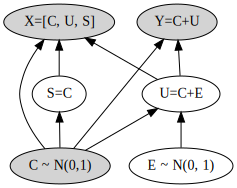

In [2]:
dot = Digraph()

dot.node('X', 'X=[C, U, S]', style='filled', fillcolor='lightgray')
dot.node('C', 'C ~ N(0,1)', style='filled', fillcolor='lightgray')
dot.node('Y', 'Y=C+U', style='filled', fillcolor='lightgray')
dot.node('U', 'U=C+E')
dot.node('E', 'E ~ N(0, 1)')
dot.node('S', 'S=C')
dot.edges(['UY', 'CY', 'CS', 'EU', 'SX', 'CX', 'UX', 'CU'])
# dot.edge('Z', 'S', style='dashed')

dot.graph_attr['rankdir'] = 'BT'
dot.render('figures/counter_example')
dot

This case is interesting b/c the problem is linear and U is correlated with S

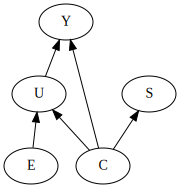

          C         U         S         E         Y
0  0.680357 -0.035745  0.680357 -0.716102  0.644612
1  0.369620 -0.886447  0.369620 -1.256067 -0.516827
2 -0.926295 -1.174667 -0.926295 -0.248372 -2.100963
3 -0.854659  0.146797 -0.854659  1.001456 -0.707863
4  0.781629 -0.977477  0.781629 -1.759106 -0.195848
5 -0.181555  0.251522 -0.181555  0.433076  0.069967
6  0.573363 -0.272445  0.573363 -0.845807  0.300918
7 -0.087181 -0.505520 -0.087181 -0.418339 -0.592701
8  0.582170  2.194614  0.582170  1.612444  2.776783
9  0.157750 -1.888730  0.157750 -2.046480 -1.730980


,C,U,S,E,Y
0,-0.514670,0.098552,0.0,0.613222,-0.416118
1,0.012562,0.357163,0.0,0.344602,0.369725
2,0.235658,-1.061080,0.0,-1.296737,-0.825422
3,0.322854,2.113817,0.0,1.790963,2.436671
4,-0.372123,-0.888298,0.0,-0.516176,-1.260421
5,1.511392,0.540838,0.0,-0.970553,2.052230
6,0.286498,-0.140933,0.0,-0.427430,0.145565
7,0.264954,0.504604,0.0,0.239650,0.769558
8,0.407704,-0.247651,0.0,-0.655355,0.160053
9,0.241180,-0.056905,0.0,-0.298085,0.184276


In [3]:
def build_graph():
    '''
    build and return a graph (list of nodes), to be runnable in main
    '''
    c = Node('C')
    e = Node('E')
    s = Node('S', lambda c: c, [c])
    u = Node('U', lambda c, e: c + e, [c, e])
    y  = Node('Y', lambda c, u: c+u,
              [c, u], is_target_node=True)
    
    # initialize the values from data
    graph = Graph([c, u, s, e, y])   
    return graph

graph = build_graph() # the causal graph
graph.draw()
n = 10
print(sample_graph(graph, {'C': np.random.randn(n), 'E': np.random.randn(n)})[['C', 'U', 'S', 'E', 'Y']])
sample_graph(graph, {'C': np.random.randn(n), 'E': np.random.randn(n), 'S': np.zeros(n)})[['C', 'U', 'S', 'E', 'Y']]

In [4]:
n = 100000
bs = 100
wd = 1e-4

XYC = sample_graph(graph, {'C': np.random.randn(n), 'E': np.random.randn(n)})[['C', 'U', 'S', 'Y']]
XYC_te = sample_graph(graph, {'C': np.random.randn(n), 'E': np.random.randn(n)})[['C', 'U', 'S', 'Y']]
XYC_deploy = sample_graph(graph, {'C': np.random.randn(n), 'E': np.random.randn(n), 'S': np.zeros(n)})[['C', 'U', 'S', 'Y']]

def get_X_Y_C(XYC):
    X = np.array(XYC[['C', 'U', 'S']])
    Y = np.array(XYC[['Y']])
    C = np.array(XYC[['C']])
    return torch.from_numpy(X).float(), torch.from_numpy(Y).float(), torch.from_numpy(C).float()

X, Y, C = get_X_Y_C(XYC)
d = X.shape[1]
X_te, Y_te, C_te = get_X_Y_C(XYC_te)
X_de, Y_de, C_de = get_X_Y_C(XYC_deploy)
r = torch.zeros(d) # concept mask
r[0] = 1

# accuracy
mse_criterion = lambda o, y: F.mse_loss(o, y)

# dataset
loader_xy = DataLoader(TensorDataset(X, Y), batch_size=bs, shuffle=True) # regular dataset
loader_xy_te = DataLoader(TensorDataset(X_te, Y_te), batch_size=bs, shuffle=False) # regular dataset
loader_xy_de = DataLoader(TensorDataset(X_de, Y_de), batch_size=bs, shuffle=False) # regular dataset

train step for 1 epoch: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 639.79it/s]


epoch   0: loss 2.061e+00


train step for 1 epoch: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 974.14it/s]


epoch   1: loss 1.879e-01


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1011.20it/s]


epoch   2: loss 3.998e-02


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1020.74it/s]


epoch   3: loss 3.548e-03


train step for 1 epoch: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 988.17it/s]


epoch   4: loss 7.174e-05


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1019.96it/s]


epoch   5: loss 1.404e-07


train step for 1 epoch: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 719.98it/s]


epoch   6: loss 1.298e-09


train step for 1 epoch: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 780.16it/s]


epoch   7: loss 1.247e-09


train step for 1 epoch: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 950.48it/s]


epoch   8: loss 1.250e-09


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1001.11it/s]


epoch   9: loss 1.251e-09


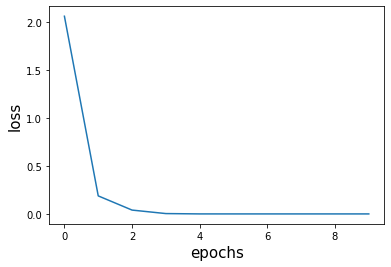

In [5]:
def standard_model(loader_xy, d, n_epochs=10, report_every=1, plot=True, weight_decay=0):
    # regular model
    net = MLP([d, 1])
    
    # train
    opt = optim.Adam(net.parameters(), weight_decay=weight_decay)
    log = train(net, loader_xy, opt, n_epochs=n_epochs, report_every=report_every, criterion=nn.MSELoss())
    if plot: plot_log(log)
    return net

n_epochs = 10
STD = standard_model(loader_xy, d, n_epochs=n_epochs, report_every=max(n_epochs//10,1), weight_decay=wd)

In [6]:
# ['C', 'U', 'S']
list(STD.classifier[0].parameters())

[Parameter containing:
 tensor([[0.4788, 1.0000, 0.5212]], requires_grad=True),
 Parameter containing:
 tensor([-4.6291e-06], requires_grad=True)]

train step for 1 epoch: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 708.88it/s]


epoch   0: loss 1.060e+00


train step for 1 epoch: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 824.75it/s]


epoch   1: loss 1.503e-01


train step for 1 epoch: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 819.18it/s]


epoch   2: loss 7.563e-02


train step for 1 epoch: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 685.54it/s]


epoch   3: loss 6.503e-02


train step for 1 epoch: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 648.07it/s]


epoch   4: loss 6.216e-02


train step for 1 epoch: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 780.61it/s]


epoch   5: loss 5.832e-02


train step for 1 epoch: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 831.64it/s]


epoch   6: loss 5.337e-02


train step for 1 epoch: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 688.08it/s]


epoch   7: loss 4.876e-02


train step for 1 epoch: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 632.72it/s]


epoch   8: loss 4.814e-02


train step for 1 epoch: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 698.36it/s]


epoch   9: loss 4.814e-02


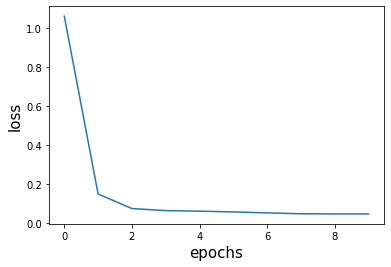

In [32]:
def CCM(loader_xy, r, n_epochs=10, report_every=1, plot=True, weight_decay=0):
    # regular model
    net = MLP([len(r), 1])

    # train
    criterion = lambda o_y, y: F.mse_loss(o_y, y) + 2e-2 * EYE(r, net.classifier[0].weight.abs().sum(0))
    # criterion = lambda o_y, y: F.mse_loss(o_y, y) + 0.05 * wL1(r, net.classifier[0].weight.abs().sum(0))
    # criterion = lambda o_y, y: F.mse_loss(o_y, y) + 0.1 * wL2(r, net.classifier[0].weight.abs().sum(0))

    opt = optim.Adam(net.parameters(), weight_decay=weight_decay)
    log = train(net, loader_xy, opt, n_epochs=n_epochs, report_every=report_every, criterion=criterion)
    if plot: plot_log(log)
    return net

n_epochs = 10
ccm = CCM(loader_xy, r, n_epochs=n_epochs, report_every=max(n_epochs//10,1), weight_decay=wd)

In [33]:
# ['C', 'U', 'S']
list(ccm.classifier[0].parameters())

[Parameter containing:
 tensor([[1.0026e+00, 9.9014e-01, 3.9908e-04]], requires_grad=True),
 Parameter containing:
 tensor([-0.0007], requires_grad=True)]

train step for 1 epoch: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 837.49it/s]


epoch   0: loss 7.051e+00


train step for 1 epoch: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 983.38it/s]


epoch   1: loss 3.633e+00


train step for 1 epoch: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 981.82it/s]


epoch   2: loss 1.891e+00


train step for 1 epoch: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 821.49it/s]


epoch   3: loss 1.196e+00


train step for 1 epoch: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 723.89it/s]


epoch   4: loss 1.020e+00


train step for 1 epoch: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 917.29it/s]


epoch   5: loss 9.998e-01


train step for 1 epoch: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 991.32it/s]


epoch   6: loss 9.991e-01


train step for 1 epoch: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 988.54it/s]


epoch   7: loss 9.990e-01


train step for 1 epoch: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 984.66it/s]


epoch   8: loss 9.990e-01


train step for 1 epoch: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 990.65it/s]


epoch   9: loss 9.991e-01


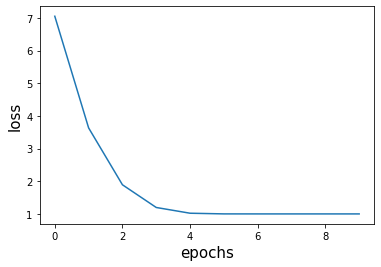

In [9]:
def CBM(loader_xy, r, n_epochs=10, report_every=1, plot=True, weight_decay=0):
    net = nn.Sequential(SubColumnNet(r.bool()), MLP([int(sum(r).item()), 1]))

    # train
    opt = optim.Adam(net.parameters(), weight_decay=weight_decay)
    log = train(net, loader_xy, opt, n_epochs=n_epochs, report_every=report_every, criterion=nn.MSELoss())
    if plot: plot_log(log)
    return net

n_epochs = 10
cbm = CBM(loader_xy, r, n_epochs=n_epochs, report_every=max(n_epochs//10,1), weight_decay=wd)

In [10]:
list(cbm[1].classifier[0].parameters())

[Parameter containing:
 tensor([[1.9950]], requires_grad=True),
 Parameter containing:
 tensor([0.0016], requires_grad=True)]

train step for 1 epoch: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 776.61it/s]


epoch   0: loss 2.239e-01


train step for 1 epoch: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 916.46it/s]


epoch   1: loss 7.325e-03


train step for 1 epoch: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 915.85it/s]


epoch   2: loss 1.788e-05


train step for 1 epoch: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 874.30it/s]


epoch   3: loss 8.503e-09


train step for 1 epoch: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 914.47it/s]


epoch   4: loss 6.243e-09


train step for 1 epoch: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 823.15it/s]


epoch   5: loss 6.226e-09


train step for 1 epoch: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 915.97it/s]


epoch   6: loss 6.239e-09


train step for 1 epoch: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 775.16it/s]


epoch   7: loss 6.271e-09


train step for 1 epoch: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 896.82it/s]


epoch   8: loss 6.286e-09


train step for 1 epoch: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 762.83it/s]


epoch   9: loss 6.329e-09


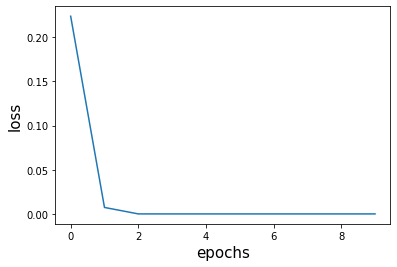

In [34]:
def Res(loader_xy, cbm, d, n_epochs=10, report_every=1, plot=True, weight_decay=0):
    net = MLP([d, 1])    
    net = CCM_res(cbm, net)

    # train
    opt = optim.Adam(net.parameters(), weight_decay=weight_decay)
    # opt = optim.SGD(net.parameters(), lr=0.01, weight_decay=weight_decay)
    log = train(net, loader_xy, opt, n_epochs=n_epochs, report_every=report_every, criterion=nn.MSELoss())
    if plot: plot_log(log)
    return net

n_epochs = 10
res = Res(loader_xy, cbm, d, n_epochs=n_epochs, report_every=max(n_epochs//10,1), weight_decay=wd)

In [35]:
list(res.net2.classifier[0].parameters())

[Parameter containing:
 tensor([[-0.4697,  0.9999, -0.5252]], requires_grad=True),
 Parameter containing:
 tensor([-0.0016], requires_grad=True)]

In [36]:
print('Before distribution shift')
print('task mse EYE after training: {:.1e}'.format(test(ccm, loader_xy_te, mse_criterion)))
print('task mse RES after training: {:.1e}'.format(test(res, loader_xy_te, mse_criterion)))
print('task mse CBM after training: {:.1e}'.format(test(cbm, loader_xy_te, mse_criterion)))
print('task mse STD(X) after training: {:.1e}'.format(test(STD, loader_xy_te, mse_criterion)))

Before distribution shift


test eval: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1572.94it/s]


task mse EYE after training: 1.5e-04


test eval: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1346.44it/s]


task mse RES after training: 5.7e-09


test eval: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1354.46it/s]


task mse CBM after training: 1.0e+00


test eval: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1580.33it/s]

task mse STD(X) after training: 1.2e-09


In [37]:
print('After distribution shift')
print('task mse EYE after training: {:.1e}'.format(test(ccm, loader_xy_de, mse_criterion)))
print('task mse RES after training: {:.1e}'.format(test(res, loader_xy_de, mse_criterion)))
print('task mse CBM after training: {:.1e}'.format(test(cbm, loader_xy_de, mse_criterion)))
print('task mse STD(X) after training: {:.1e}'.format(test(STD, loader_xy_de, mse_criterion)))

After distribution shift


test eval: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1552.73it/s]


task mse EYE after training: 1.5e-04


test eval: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 879.74it/s]


task mse RES after training: 2.8e-01


test eval: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1338.52it/s]


task mse CBM after training: 1.0e+00


test eval: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1360.29it/s]

task mse STD(X) after training: 2.7e-01
